In [1]:
import pandas as pd
import numpy as np 
import re
import rpy2.robjects as robjects

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, median_absolute_error
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [2]:
abbrev = pd.read_csv("abbrev.csv")
abbrev.head()

,Unnamed: 0,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,prc_fam_poverty,...,cases_april23,cases_april25,cases_may11,ten_plus,order,density,death_prc,cases_prc,prc_incarcerated,uninsured
0,0,2.56,1.079230,11.181199,19.409400,8.323099,22.213539,10.247107,5.654795,9.9,...,50,55,95,44,37,205.559775,0.000000,0.000311,0.005072,1.185668
1,1,3.15,14.810805,7.410151,21.601702,8.941190,7.127118,9.305904,4.424056,15.6,...,35,47,319,29,53,108.941861,0.000007,0.000059,0.003072,9.905791
2,2,3.31,15.989974,10.084580,19.673111,10.873224,6.512608,8.971354,3.888164,10.5,...,154,169,279,51,53,132.778760,0.000014,0.000181,0.002133,3.714698
3,3,2.37,1.339175,16.368947,20.669588,11.533536,3.509718,10.598809,6.790248,5.1,...,36,37,41,44,53,104.091797,0.000010,0.000341,0.001976,1.227732
4,4,2.59,1.066778,9.394248,25.461959,11.484731,4.417867,12.854456,5.007969,9.5,...,28,30,32,38,53,47.687662,0.000022,0.000133,0.001883,0.826483


In [3]:
abbrev = abbrev.drop('Unnamed: 0', axis=1)
abbrev.columns.values

array(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing',
       'empl_retail', 'empl_transp_utilities', 'prc_fam_poverty',
       'avg_income', 'prc_public_transp', 'population', 'pop_65_plus',
       'aa_and_mixed', 'aa', 'latino', 'immigrant', 'county', 'state',
       'FIPS', 'area', 'prc_obese', 'nh_weighted_health_score',
       'nh_num_beds', 'nh_prc_occupied', 'nh_nurse_hours',
       'nh_total_fines', 'nh_overall_rating', 'incarcerated',
       'domestic_passengers', 'intl_passengers', 'deaths_march24',
       'deaths_april1', 'deaths_april11', 'deaths_april23',
       'deaths_april25', 'deaths', 'cases_march24', 'cases_april1',
       'cases_april11', 'cases_april23', 'cases_april25', 'cases_may11',
       'ten_plus', 'order', 'density', 'death_prc', 'cases_prc',
       'prc_incarcerated', 'uninsured'], dtype=object)

In [5]:
predictors = ['population','household_size', 'empl_agriculture', 'empl_professional',
              'empl_social', 'empl_services', 'empl_manufacturing',
              'empl_retail', 'empl_transp_utilities', 'prc_fam_poverty',
              'avg_income', 'prc_public_transp', 'pop_65_plus', 'aa', 
              'latino', 'immigrant', 'prc_obese', 'nh_weighted_health_score',
              'nh_num_beds', 'nh_prc_occupied', 'nh_nurse_hours',
              'nh_total_fines', 'nh_overall_rating', 'incarcerated',
              'domestic_passengers', 'intl_passengers', 'ten_plus', 'order', 
              'density', 'death_prc', 'cases_prc', 'uninsured']

predictors_noCaseData = predictors.copy()
predictors_noCaseData.remove('cases_prc')

transform = ["population", "density", "intl_passengers", "domestic_passengers",  
             "incarcerated", "empl_agriculture", "prc_public_transp", "cases_prc",
             "uninsured"]

for field in transform:
    abbrev.loc[abbrev[field] == 0, field] = 0.0000001
    abbrev["log_"+field] = np.log1p(abbrev[field])
    
log_predictors = predictors.copy()
for field in transform:
    log_predictors.remove(field)
    log_predictors.append("log_"+field)
    
log_predictors_noCaseData = log_predictors.copy()
log_predictors_noCaseData.remove('log_cases_prc')

In [6]:
indp_vars = [predictors_noCaseData, predictors, 
             log_predictors_noCaseData, log_predictors]
labels = ["no case data", "with case data", 
          "with transformed predictors, no case data", 
          "with transformed predictors, with case data"]

In [7]:
abbrev["log_death_prc"] = np.log1p(abbrev["death_prc"])

In [8]:
# apply standard scaling to predictors

original = abbrev.copy()
all_predictors = set()
for x in indp_vars:
    all_predictors = all_predictors.union(x)
    
all_predictors = list(all_predictors)
scaler = StandardScaler()
scaler.fit(abbrev[all_predictors])
abbrev[all_predictors] = scaler.transform(abbrev[all_predictors])

abbrev[all_predictors].describe()

,aa,pop_65_plus,death_prc,log_uninsured,empl_services,intl_passengers,log_population,log_incarcerated,domestic_passengers,population,...,nh_weighted_health_score,density,cases_prc,immigrant,avg_income,prc_obese,log_empl_agriculture,uninsured,prc_public_transp,log_prc_public_transp
count,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,...,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02
mean,2.414769e-17,1.733465e-16,7.920575e-17,2.173460e-16,-3.557547e-17,3.503848e-16,-9.645367e-16,5.040976e-16,-9.591951e-17,-3.208504e-17,...,1.060552e-17,1.612643e-17,-7.685643e-18,-2.369460e-17,-3.040695e-17,2.213734e-16,1.005510e-16,-2.966860e-17,-2.940010e-17,-2.013706e-17
std,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,...,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00
min,-8.668635e-01,-2.110942e+00,-5.513161e-01,-1.571388e+00,-3.473266e+00,-2.566046e-01,-1.270937e+00,-3.802689e+00,-4.539130e-01,-4.640806e-01,...,-1.370365e+00,-2.498650e-01,-5.042505e-01,-1.081821e+00,-2.214456e+00,-3.177501e+00,-1.470589e+00,-7.802343e-01,-3.915309e-01,-1.043367e+00
25%,-6.804759e-01,-6.369323e-01,-4.848050e-01,-6.660829e-01,-6.117986e-01,-2.566046e-01,-7.966149e-01,-3.039255e-01,-4.539130e-01,-4.073826e-01,...,-7.126995e-01,-2.096455e-01,-3.670093e-01,-6.707358e-01,-6.593107e-01,-6.437849e-01,-7.306919e-01,-4.873042e-01,-3.371632e-01,-6.770501e-01
50%,-3.503566e-01,-9.638015e-02,-3.492783e-01,-2.996472e-01,-1.329819e-01,-2.566046e-01,-2.306876e-01,8.582683e-02,-4.217655e-01,-2.988431e-01,...,-1.842705e-01,-1.708331e-01,-2.759734e-01,-3.083805e-01,-1.795283e-01,8.147965e-02,-2.452055e-01,-3.285949e-01,-2.646729e-01,-3.024958e-01
75%,2.821226e-01,4.452745e-01,-4.648935e-04,3.628486e-01,4.316509e-01,-2.566046e-01,6.043379e-01,5.184642e-01,-2.177694e-01,6.448881e-03,...,4.072415e-01,-8.304943e-02,-4.187066e-02,2.426092e-01,4.667065e-01,6.937159e-01,5.674362e-01,3.755312e-02,-6.532455e-02,3.942034e-01
max,5.025472e+00,9.470146e+00,7.781680e+00,4.861119e+00,8.014222e+00,8.051965e+00,4.360334e+00,2.576654e+00,4.477269e+00,1.655084e+01,...,1.023941e+01,2.082053e+01,1.044055e+01,6.246698e+00,5.451130e+00,3.133242e+00,4.155522e+00,9.951393e+00,1.060887e+01,4.712229e+00


# Decision Tree

# Random Forest


# XGBoost

In [9]:
dtrain = xgb.DMatrix(abbrev[indp_vars[0]], label=abbrev["death_prc"])
dtrain2 = xgb.DMatrix(abbrev[indp_vars[0]], label=abbrev["log_death_prc"])
dtrain3 = xgb.DMatrix(abbrev[indp_vars[1]], label=abbrev["death_prc"])
dtrain4 = xgb.DMatrix(abbrev[indp_vars[1]], label=abbrev["log_death_prc"])

dtrain5 = xgb.DMatrix(abbrev[indp_vars[2]], label=abbrev["death_prc"])
dtrain6 = xgb.DMatrix(abbrev[indp_vars[2]], label=abbrev["log_death_prc"])
dtrain7 = xgb.DMatrix(abbrev[indp_vars[3]], label=abbrev["death_prc"])
dtrain8 = xgb.DMatrix(abbrev[indp_vars[3]], label=abbrev["log_death_prc"])

### no case data, raw deaths

In [ ]:
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py
# using xgboost's built-in cross validation, will manually implement a grid search myself

md = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
eta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma  = [0, 0.3, 0.5, 0.8, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain, num_round, nfold=10, seed=1001, 
                   callbacks=[#xgb.callback.print_evaluation(show_stdv=True),
                              xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[1]	train-rmse:1.11794+0.01440	test-rmse:1.11034+0.12745

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.11794+0.01440	test-rmse:1.11034+0.12745

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.11794+0.01440	test-rmse:1.11034+0.12745

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.11794+0.01440	test-rmse:1.11034+0.12745

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train

In [ ]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

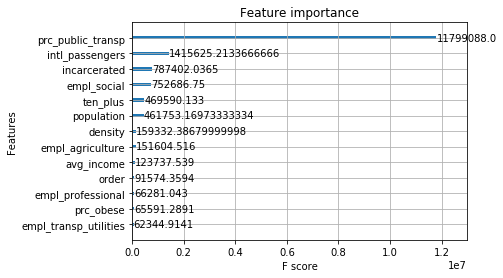

In [166]:
param = {'max_depth':2, 'eta':0.8, 'gamma':0.8, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain)
xgb.plot_importance(xgb_model, importance_type="gain")#"cover")

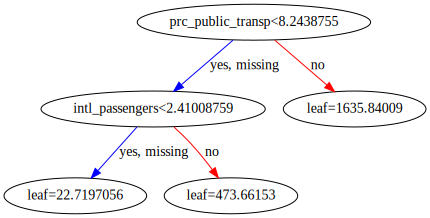

In [164]:
xgb.to_graphviz(xgb_model)
#.get_booster().get_score(importance_type= "score")

In [140]:
abbrev.loc[abbrev.prc_public_transp > 8.2, ["state", "county", "population", "deaths", "cases_march24"]]

,state,county,population,deaths,cases_march24
284,NY,Bronx County,1.856199,2342.0,8.454422
489,NY,New York County,2.189230,1390.0,9.685109
588,NY,Kings County,3.805736,3190.0,14.227519
688,NY,Queens County,3.290822,3304.0,15.495312


In [167]:
abbrev.loc[(abbrev.prc_public_transp <=8.244) & (abbrev.intl_passengers <= 2.41), ["state", "county", "population", "deaths", "cases_march24"]].describe()

,population,deaths,cases_march24
count,811.000000,811.000000,811.000000
mean,-0.050668,28.934649,-0.091344
std,0.774948,95.422773,0.280013
min,-0.464081,0.000001,-0.169662
25%,-0.409280,1.000000,-0.163478
50%,-0.303458,5.000000,-0.154201
75%,-0.032305,17.000000,-0.117095
max,8.206754,1396.000000,4.338733


### no case data, with log-transformed response

In [182]:
md = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
eta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma  = [0, 0.3, 0.5, 0.8, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain2, num_round, nfold=10, seed=1001, 
                   callbacks=[#xgb.callback.print_evaluation(show_stdv=True),
                              xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.26774+0.02286	test-rmse:2.25708+0.21220

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.26774+0.02286	test-rmse:2.25708+0.21220

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.26774+0.02286	test-rmse:2.25708+0.21220

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.26774+0.02286	test-rmse:2.25708+0.21220

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train

In [243]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.2, gamma = 1, with mean RMSE = 1.0170556999999998


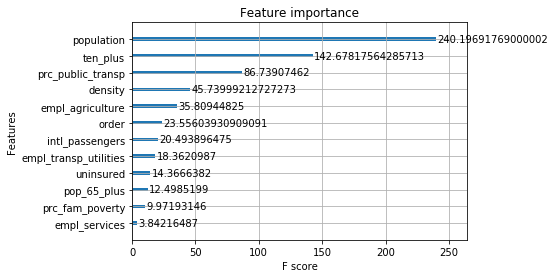

In [184]:
param = {'max_depth':3, 'eta':0.1, 'gamma':0, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain2)
xgb.plot_importance(xgb_model, importance_type="gain")#"cover")

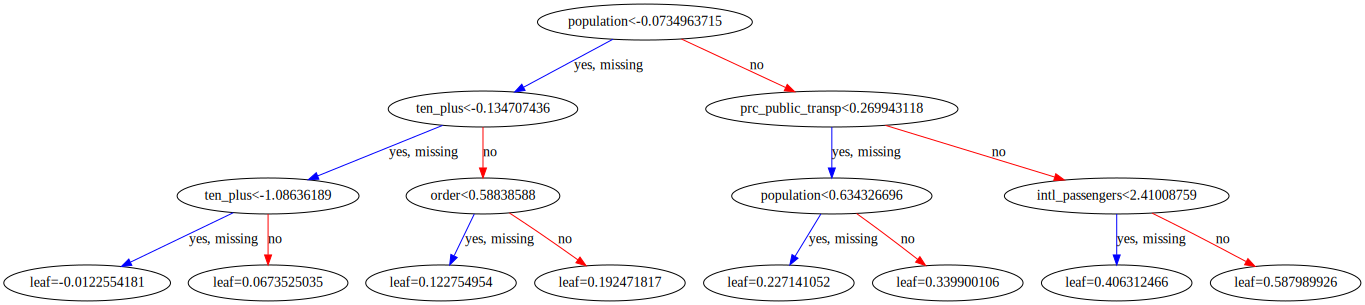

In [185]:
xgb.to_graphviz(xgb_model)

### with case data, raw deaths

In [197]:
md = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
eta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma  = [0, 0.3, 0.5, 0.8, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain3, num_round, nfold=10, seed=1001, 
                   callbacks=[#xgb.callback.print_evaluation(show_stdv=True),
                              xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[2]	train-rmse:227.14957+20.49017	test-rmse:184.39815+133.60361

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[1]	train-rmse:227.14957+20.49018	test-rmse:184.39815+133.60361

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[2]	train-rmse:227.14958+20.49017	test-rmse:184.39816+133.60361

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[1]	train-rmse:227.14957+20.49017	test-rmse:184.39816+133.60361

Multiple eval metrics have been passed: 'test-rmse' will be used for

In [198]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 2, eta = 0.4, gamma = 0.3, with mean RMSE = 97.6522255


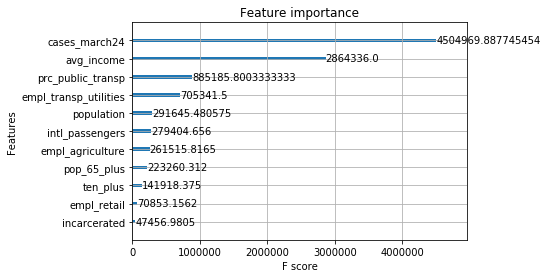

In [199]:
param = {'max_depth':2, 'eta':0.4, 'gamma':0.3, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain3)
xgb.plot_importance(xgb_model, importance_type="gain")#"cover")

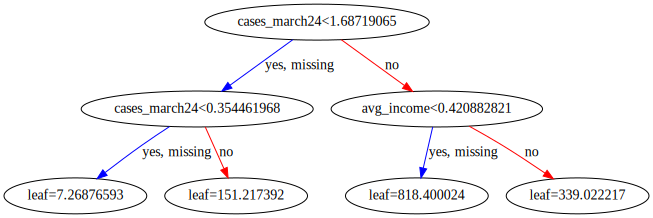

In [201]:
xgb.to_graphviz(xgb_model)

## experiment...

In [273]:
abbrev.loc[abbrev.cases_april1 >= 50,].shape

(315, 42)

In [274]:
dtrain_ex0 = xgb.DMatrix(abbrev[indp_vars[0]], label=abbrev["deaths_bin"])
dtrain_ex1 = xgb.DMatrix(abbrev[indp_vars[1]], label=abbrev["deaths_bin"])
dtrain_ex2 = xgb.DMatrix(abbrev[indp_vars[2]], label=abbrev["deaths_bin"])
dtrain_ex3 = xgb.DMatrix(abbrev[indp_vars[3]], label=abbrev["deaths_bin"])

dtrain_ex4 = xgb.DMatrix(abbrev.loc[abbrev.cases_april1 >= 50, indp_vars[0]], label=abbrev.loc[abbrev.cases_april1 >= 50, "deaths"])
dtrain_ex5 = xgb.DMatrix(abbrev.loc[abbrev.cases_april1 >= 50, indp_vars[1]], label=abbrev.loc[abbrev.cases_april1 >= 50, "deaths"])
dtrain_ex6 = xgb.DMatrix(abbrev.loc[abbrev.cases_april1 >= 50, indp_vars[2]], label=abbrev.loc[abbrev.cases_april1 >= 50, "deaths"])
dtrain_ex7 = xgb.DMatrix(abbrev.loc[abbrev.cases_april1 >= 50, indp_vars[3]], label=abbrev.loc[abbrev.cases_april1 >= 50, "deaths"])

In [254]:
md = [3,4,5,6,7,8,9,10]
eta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma  = [0, 0.3, 0.5, 0.8, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain_ex0, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train

In [255]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.5, gamma = 0.3, with mean RMSE = 1.1955864


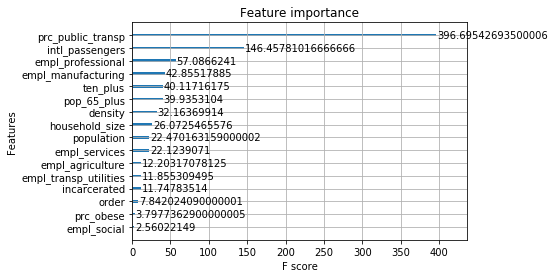

In [262]:
param = {'max_depth':3, 'eta':0.5, 'gamma':0.3, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain_ex0)
xgb.plot_importance(xgb_model, importance_type="gain")#"cover")

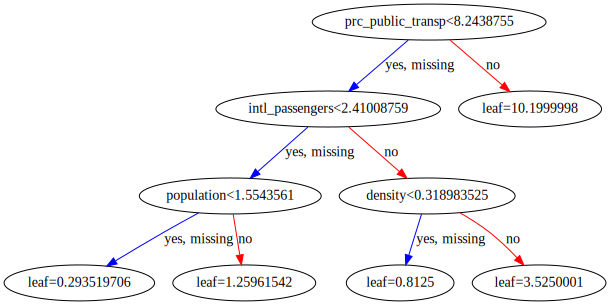

In [263]:
xgb.to_graphviz(xgb_model)

In [256]:
md = [3,4,5,6,7,8,9,10]
eta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma  = [0, 0.3, 0.5, 0.8, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain_ex1, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train

In [257]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.2, gamma = 1, with mean RMSE = 1.0170556999999998


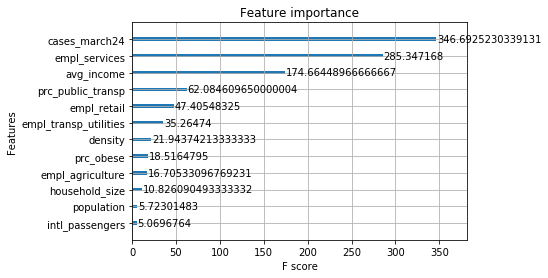

In [264]:
param = {'max_depth':3, 'eta':0.2, 'gamma':1, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain_ex1)
xgb.plot_importance(xgb_model, importance_type="gain")#"cover")

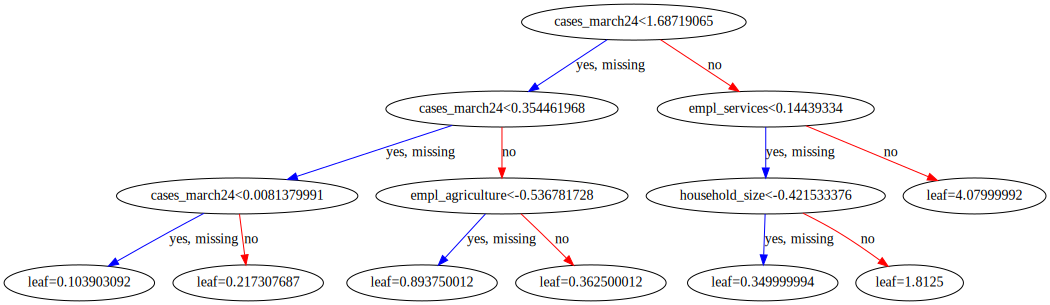

In [265]:
xgb.to_graphviz(xgb_model)

In [258]:
md = [3,4,5,6,7,8,9,10]
eta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma  = [0, 0.3, 0.5, 0.8, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain_ex2, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train

In [259]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.5, gamma = 0, with mean RMSE = 1.1301461


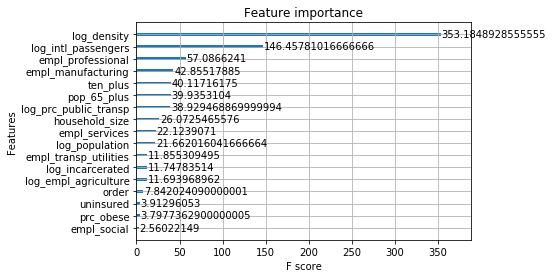

In [266]:
param = {'max_depth':3, 'eta':0.5, 'gamma':0, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain_ex2)
xgb.plot_importance(xgb_model, importance_type="gain")#"cover")

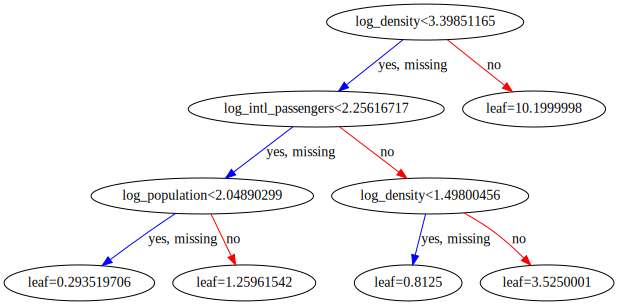

In [267]:
xgb.to_graphviz(xgb_model)

In [260]:
md = [3,4,5,6,7,8,9,10]
eta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma  = [0, 0.3, 0.5, 0.8, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain_ex3, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:2.30951+0.20122	test-rmse:1.91909+1.29427

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train

In [261]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 4, eta = 0.8, gamma = 1.5, with mean RMSE = 1.0155649


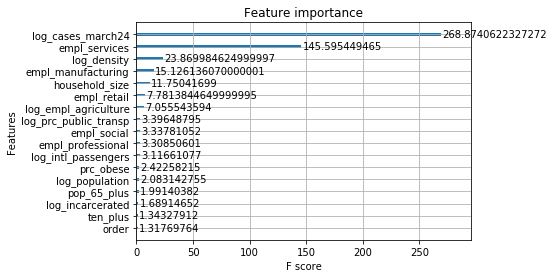

In [269]:
param = {'max_depth':4, 'eta':0.8, 'gamma':1.5, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain_ex3)
xgb.plot_importance(xgb_model, importance_type="gain")#"cover")

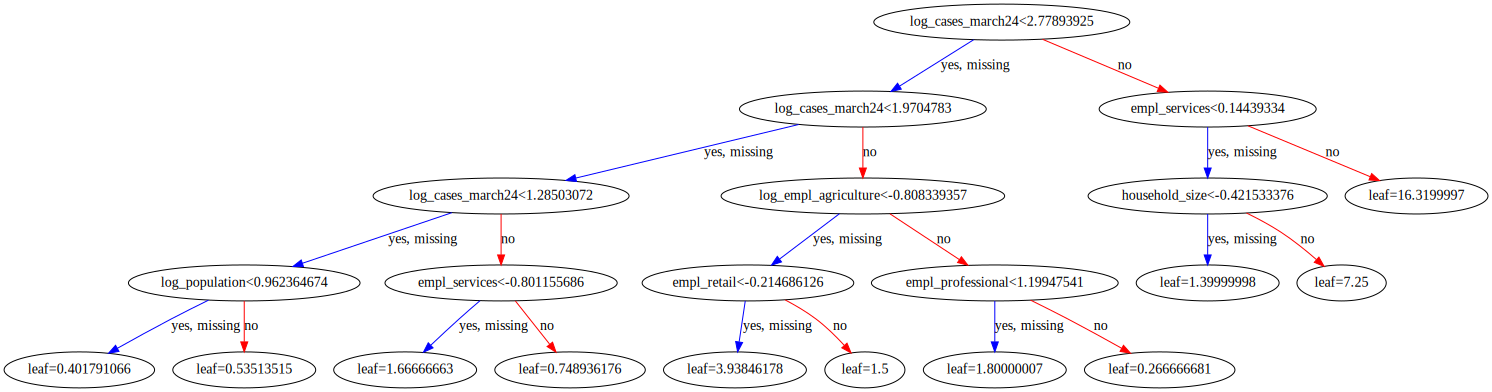

In [270]:
xgb.to_graphviz(xgb_model)

#### with only those counties with 50+ cases as of april1

In [275]:
md = [3,4,5,6,7,8,9,10]
eta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma  = [0, 0.3, 0.5, 0.8, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain_ex4, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[3]	train-rmse:368.05594+32.23218	test-rmse:295.42205+222.27231

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[2]	train-rmse:368.05595+32.23218	test-rmse:295.42205+222.27231

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[2]	train-rmse:368.05594+32.23218	test-rmse:295.42205+222.27231

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:368.05594+32.23218	test-rmse:295.42205+222.27231

Multiple eval metrics have been passed: 'test-rmse' will be used for

In [276]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 4, eta = 0.7, gamma = 0.5, with mean RMSE = 150.0044866


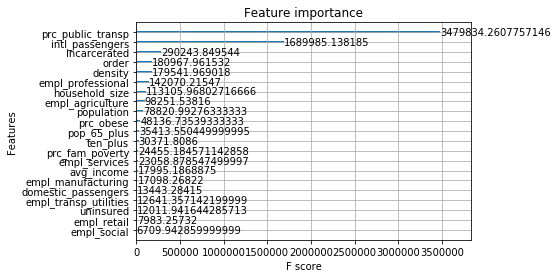

In [277]:
param = {'max_depth':4, 'eta':0.7, 'gamma':0.5, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain_ex4)
xgb.plot_importance(xgb_model, importance_type="gain")#"cover")

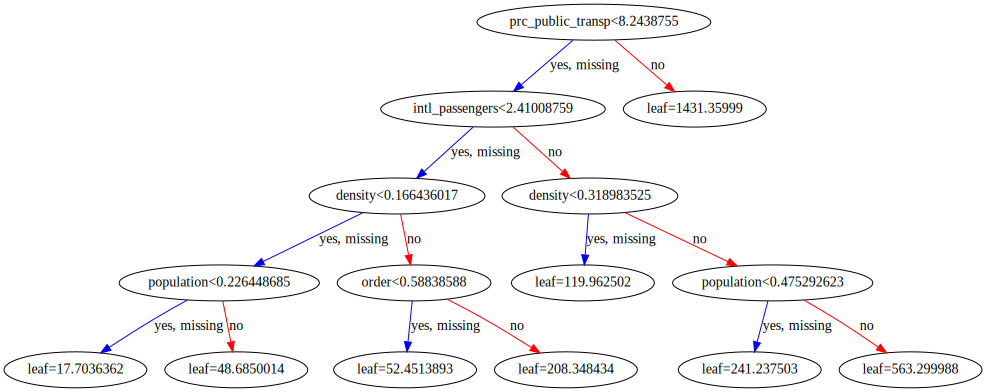

In [278]:
xgb.to_graphviz(xgb_model)

In [279]:
md = [3,4,5,6,7,8,9,10]
eta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma  = [0, 0.3, 0.5, 0.8, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain_ex5, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[1]	train-rmse:368.05594+32.23218	test-rmse:295.42206+222.27232

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[1]	train-rmse:368.05594+32.23218	test-rmse:295.42205+222.27231

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:368.05594+32.23218	test-rmse:295.42205+222.27231

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[1]	train-rmse:368.05594+32.23218	test-rmse:295.42205+222.27231

Multiple eval metrics have been passed: 'test-rmse' will be used for

In [280]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 4, eta = 0.4, gamma = 0.5, with mean RMSE = 139.26679699999997


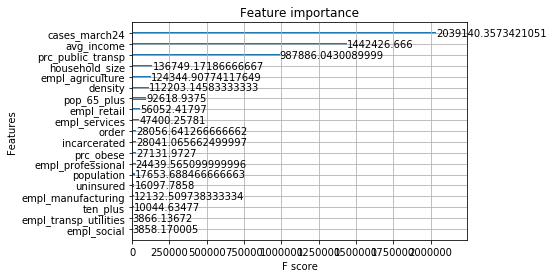

In [281]:
param = {'max_depth':4, 'eta':0.4, 'gamma':0.5, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain_ex5)
xgb.plot_importance(xgb_model, importance_type="gain")#"cover")

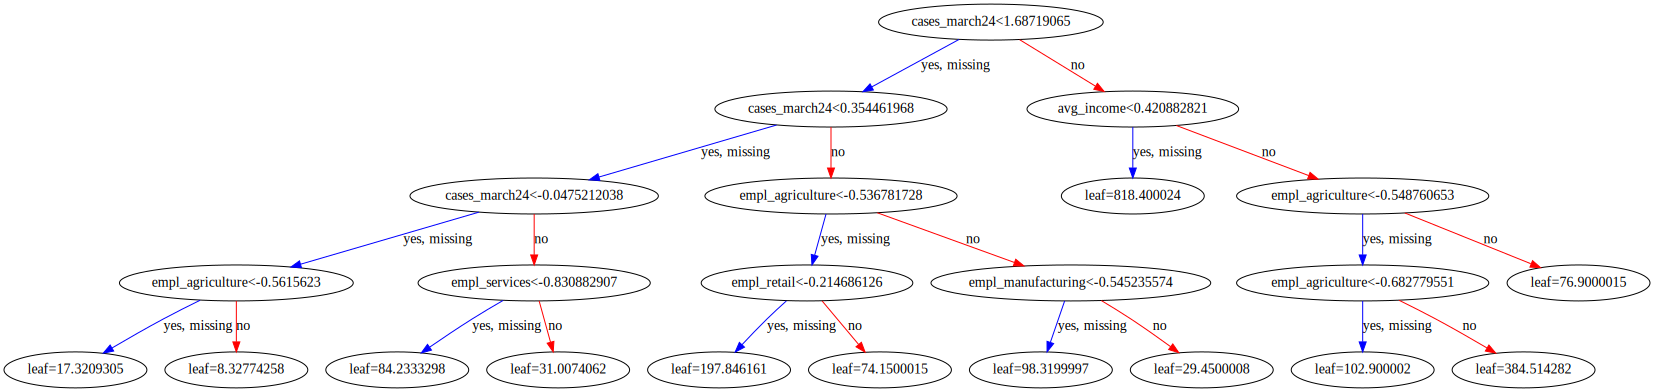

In [282]:
xgb.to_graphviz(xgb_model)

### try with poisson objective

In [75]:
param = {'max_depth':10, 'eta':0.7, 'gamma':0.7, 'silent':1, 'objective':'count:poisson'}
num_round = 100
xgb.cv(param, dtrain, num_round, nfold=10, seed=1001, 
       callbacks=[xgb.callback.print_evaluation(show_stdv=True),
                  xgb.callback.early_stop(3)])

[0]	train-poisson-nloglik:262.65753+20.06163	test-poisson-nloglik:262.16282+180.38510
Multiple eval metrics have been passed: 'test-poisson-nloglik' will be used for early stopping.

Will train until test-poisson-nloglik hasn't improved in 3 rounds.
[1]	train-poisson-nloglik:238.60229+18.66571	test-poisson-nloglik:238.18817+167.81250
[2]	train-poisson-nloglik:214.82509+17.27086	test-poisson-nloglik:214.57168+155.23795
[3]	train-poisson-nloglik:191.40805+15.88890	test-poisson-nloglik:191.46954+142.79099
[4]	train-poisson-nloglik:168.47181+14.49694	test-poisson-nloglik:170.43365+131.80635
[5]	train-poisson-nloglik:146.25117+13.10549	test-poisson-nloglik:149.30680+119.12006
[6]	train-poisson-nloglik:124.83414+11.73072	test-poisson-nloglik:129.18190+106.95731
[7]	train-poisson-nloglik:104.50257+10.36236	test-poisson-nloglik:110.23025+94.17412
[8]	train-poisson-nloglik:85.33793+9.00418	test-poisson-nloglik:94.34855+83.73064
[9]	train-poisson-nloglik:67.73005+7.69261	test-poisson-nloglik:79.

,train-poisson-nloglik-mean,train-poisson-nloglik-std,test-poisson-nloglik-mean,test-poisson-nloglik-std
0,262.657526,20.061628,262.162821,180.385103
1,238.602295,18.665706,238.188173,167.812500
2,214.825093,17.270859,214.571675,155.237950
3,191.408052,15.888900,191.469537,142.790989
4,168.471814,14.496944,170.433650,131.806354
5,146.251173,13.105487,149.306800,119.120055
6,124.834145,11.730717,129.181904,106.957307
7,104.502567,10.362359,110.230246,94.174120
8,85.337926,9.004179,94.348553,83.730644
9,67.730053,7.692606,79.438099,71.580226


In [168]:
# using best parameters to train on entire dataset - https://github.com/dmlc/xgboost/issues/92
param = {'max_depth':10, 'eta':0.7, 'gamma':0.7, 'silent':1, 'objective':'count:poisson', 'random_seed':1001}
xgb_model = xgb.train(param, dtrain)

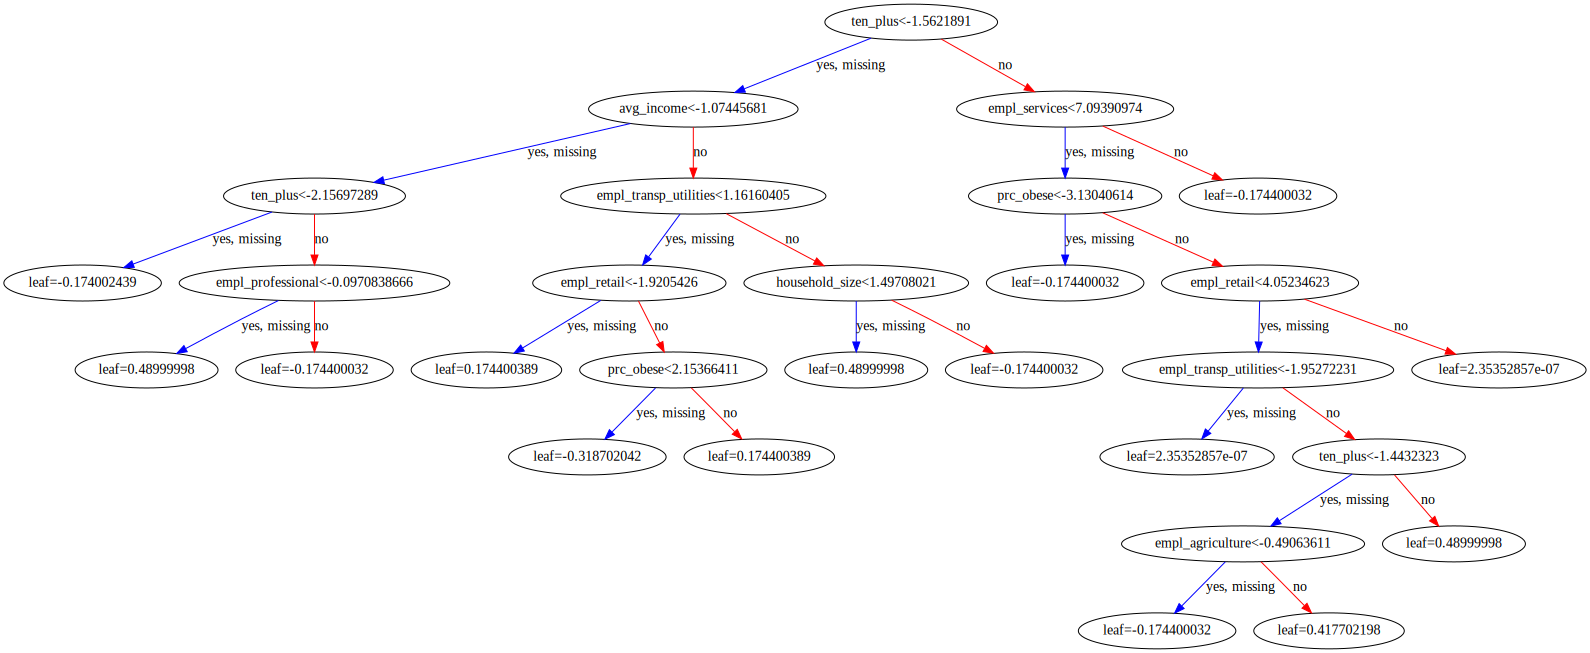

In [169]:

xgb.to_graphviz(xgb_model)
#xgb.plot_tree(xgb_model)

In [171]:
pred = xgb_model.predict(dtrain)

In [177]:
pred.mean()

15.847876

In [178]:
pred.min()

0.05907291

In [179]:
pred.max()

67.14487

In [172]:
delta = abbrev["deaths"] - pred

In [175]:
delta.describe()

count     827.000000
mean       34.206537
std       213.677106
min       -67.144866
25%        -0.843842
50%         0.000211
75%         1.903937
max      3236.855133
Name: deaths, dtype: float64